# Team Members:
| Name | ID | 
|----------|----------|
| Ahmed Nezar  | 21P0025  |
| Seif Yasser  | 21P0102  |
| Kirollos Ehab  | 21P0006  |
| AbdulRahman Hesham  | 21P0153  |
| Mohammed Yasser  | 2100921  |
| Omar Ahmed  | 22P0109  |

# Installing Required Libraries


This cell installs the required Python libraries for data preprocessing, clustering, visualization, and optimization.

In [2]:
!pip install ipympl
!pip install scipy
!pip install tqdm
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install optuna

# Imports


This cell imports all the necessary Python libraries and modules:
- **`pandas`** and **`numpy`** for data manipulation.
- **`matplotlib`** and **`seaborn`** for data visualization.
- **`scipy`** for statistical calculations and clustering utilities.
- **`optuna`** for hyperparameter optimization.
- **`tqdm`** for progress bars in loops.
- **`sklearn`** for clustering models and evaluation metrics.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage

import optuna
from tqdm import tqdm
import os
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Constants



- **`DATA_DIR`**: Path to the dataset file.
- **`RUN_DIR`**: Path where the project's directories and logs will be stored.

In [ ]:
DATA_DIR = "dataset.csv"
RUN_DIR = "."

# Utils Class


A utility class to manage preprocessing configuration, directory setup, and data loading:
- **`preprocessor_config`**: Configuration for data normalization and encoding.
  - Specifies normalization method, encoder type, excluded columns, and columns categorized as numerical or categorical.
- **`create_directories(run_dir)`**: Creates necessary directories for storing logs, models, and plots.
- **`load_data()`**: Loads the dataset from the specified path into a Pandas DataFrame.
- **`get_dir()`**: Returns paths to the created directories for easy access.

In [6]:
class Utils:
    preprocessor_config = {
        "Normalizer": "MinMaxScaler",
        "Encoder": "OneHotEncoder",
        "excls_cols": ["CustomerID"],
        "categorical_cols": ["Gender"],
        "numerical_cols": ["Age", "Annual Income (k$)", "Spending Score (1-100)"],
        # "Imputer": "SimpleImputer",
        # "Imputer_strategy": "mean",
    }

    @classmethod
    def create_directories(self, run_dir: str):
        self.log_dir = os.path.join(run_dir, "logs")
        self.data_path = "dataset.csv"
        self.model_dir = os.path.join(self.log_dir, "models")
        self.plot_dir = os.path.join(self.log_dir, "plots")
        self.raw_plots_dir = os.path.join(self.plot_dir, "raw")
        self.iqr_plots_dir = os.path.join(self.plot_dir, "iqr")
        self.zscore_plots_dir = os.path.join(self.plot_dir, "zscore")
        self.iqr_zscore_plots_dir = os.path.join(self.plot_dir, "iqr_zscore")

        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.plot_dir, exist_ok=True)
        os.makedirs(self.raw_plots_dir, exist_ok=True)
        os.makedirs(self.iqr_plots_dir, exist_ok=True)
        os.makedirs(self.zscore_plots_dir, exist_ok=True)
        os.makedirs(self.iqr_zscore_plots_dir, exist_ok=True)
        # print(f"Created directories: {self.log_dir}, {self.data_path}, {self.model_dir}")

    @classmethod
    def load_data(self):
        """
        Load the dataset from the specified path in the configuration.
        Returns:
            pd.DataFrame: The dataset.
        """
        return pd.read_csv(self.data_path)

    @classmethod
    def get_dir(self):
        return self.log_dir, self.model_dir, self.plot_dir

# Directory Setup


The `Utils.create_directories()` method is called to set up the directory structure required for the project.

In [7]:
Utils.create_directories(run_dir=RUN_DIR)

# Loading the Dataset


The `Utils.load_data()` method is used to load the dataset into a Pandas DataFrame for further processing.

In [8]:
data = Utils.load_data()

# Configuration Update


The configuration settings for normalization and encoding are updated here to use `MinMaxScaler` and `LabelEncoder`, respectively. This ensures that preprocessing aligns with the project's needs.

In [9]:
# Change the configuration here (if needed)
Utils.preprocessor_config["Normalizer"] = "MinMaxScaler"
Utils.preprocessor_config["Encoder"] = "LabelEncoder"

# EDA (Exploratory Data Analysis)


This section explores the dataset to understand its structure and properties:
1. **Dataset Overview**: Prints the number of rows and columns in the dataset.
2. **Column Names**: Displays the list of column names.
3. **Sample Data**: Shows the first few rows of the dataset using `data.head()`.
4. **Dataset Info**: Provides an overview of column types and non-null counts using `data.info()`.
5. **Missing Values**: Checks for missing values using `data.isna().sum()` and concludes there are none.
6. **Duplicate Rows**: Checks for duplicate rows using `data.duplicated().sum()` and concludes there are none.
7. **Statistical Summary**: Displays a transposed summary of numerical data using `data.describe().T`.

In [10]:
print("Dataset has ", data.shape[0], " rows and ", data.shape[1], " columns")
print("Columns are: ", list(data.columns))

Dataset has  200  rows and  5  columns
Columns are:  ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [11]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [13]:
data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [14]:
data.duplicated().sum()

np.int64(0)

> **🤔 Conclusion**: 
> - No missing values in the dataset.
> - No duplicate rows in the dataset.


In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


# Preprocessing

This section includes custom classes for data preprocessing to clean and prepare the dataset for further analysis:

### LogNormalizer

A custom normalizer that applies logarithmic transformation to reduce the impact of outliers:
- **`_Log_Normalize(X)`**: Transforms data using the formula: `sign(X) * log(abs(X) + 1)`.
- **`fit_transform(X)`**: Applies log normalization to a Pandas Series or NumPy array.


In [16]:
class LogNormalizer:
    def _Log_Normalize(self, X):
        """
        Apply log normalization to the input data.

        This method takes an input array `X` and applies log normalization to it.
        The transformation is defined as sign(X) * log(abs(X) + 1), which helps in
        handling both positive and negative values and reducing the impact of large
        outliers.

        Parameters:
        X (numpy.ndarray): The input data array to be normalized.

        Returns:
        numpy.ndarray: The log-normalized data array.
        """
        return np.sign(X) * np.log(np.abs(X) + 1)

    def fit_transform(self, X):
        """
        Fits the preprocessor to the data and transforms it.

        Parameters:
        X (pd.Series or np.ndarray): The input data to be transformed. If a pandas Series is provided, it will be converted to a numpy array.

        Returns:
        np.ndarray: The transformed data after applying log normalization.
        """
        if isinstance(X, pd.Series):
            X = X.to_numpy().reshape(-1, 1)
        return self._Log_Normalize(X)

### Preprocessor

A comprehensive class to handle data preprocessing steps:
1. **Initialization**: Takes the dataset and preprocessing configurations as inputs.
2. **Preprocessing Steps**:
   - **`preprocess()`**: Handles the entire preprocessing pipeline including dropping columns, scaling numerical data, and encoding categorical variables.
   - **`__drop_cols(col_list)`**: Drops specified columns.
   - **`__rename()`**: Renames columns for consistency (e.g., "Annual Income (k$)" to "Annual_Income").
   - **`__scale()`**: Scales numerical columns based on the specified normalizer:
     - **`MinMaxScaler`**: Scales data between 0 and 1.
     - **`StandardScaler`**: Standardizes data by removing the mean and scaling to unit variance.
     - **`LogNormalizer`**: Applies custom log normalization.
   - **`__encode()`**: Encodes categorical columns based on the specified encoder:
     - **`OneHotEncoder`**: Converts categorical variables into binary columns.
     - **`LabelEncoder`**: Converts categorical variables into numerical labels.
3. **Error Handling**:
   - Raises errors for unsupported normalizers or encoders.
4. **Validation**:
   - **`__check_nulls()`**: Checks for and handles missing values in the dataset.
   - **`__check_duplicates()`**: Removes duplicate rows if found.

In [17]:
class Preprocessor:
    def __init__(self, dataset):
        """
        Initializes the Preprocessor class.

        Attributes:
            config (dict): Configuration settings for the preprocessor.
            dataset (pd.DataFrame): The dataset loaded from the specified CSV file.
        """
        self.config = Utils.preprocessor_config
        # self.dataset = pd.read_csv(Utils.data_path)
        self.dataset = dataset
        self.dataset = self.dataset.reset_index()
        # self.Cat_columns = []

    def preprocess(self):
        """
        Preprocess the dataset by performing the following steps:
        1. Drop columns specified in the configuration.
        2. Scale the dataset.
        3. Encode categorical variables.

        Returns:
            pd.DataFrame: The preprocessed dataset.
        """
        # self.__check_nulls()
        # self.__check_duplicates()
        self.__drop_cols(self.config["excls_cols"])
        # self.__rename()
        # self.dataset = self.dataset.drop(columns=self.config["excls_cols"])
        if self.config["Normalizer"] and self.config["Normalizer"] != "None":
            self.__scale()
        self.__encode()
        return self.dataset

    def __drop_cols(self, col_list):
        """
        Drops specified columns from the dataset.
        Parameters:
        - col_list (list): List of column names to be dropped from the dataset.

        Returns:
            None
        """
        self.dataset = self.dataset.drop(columns=col_list)

    def __rename(self):
        """
        Renames specific columns in the dataset for consistency and ease of use.

        The following columns are renamed:
        - 'Annual Income (k$)' to 'Annual_Income'
        - 'Spending Score (1-100)' to 'Spending_Score'

        Returns:
            None
        """
        self.dataset = self.dataset.rename(
            columns={
                "Annual Income (k$)": "Annual_Income",
                "Spending Score (1-100)": "Spending_Score",
            }
        )

    def __scale(self):
        """
        Scales the numerical columns of the dataset based on the specified normalizer in the configuration.
        The method supports three types of normalizers:
        - MinMaxScaler: Scales features to a given range, usually between 0 and 1.
        - StandardScaler: Standardizes features by removing the mean and scaling to unit variance.
        - LogNormalizer: Custom normalizer that applies a logarithmic transformation.
        Raises:
            ValueError: If the specified normalizer in the configuration is not supported.
        Note:
            The columns specified in the configuration under "categorical_cols" are excluded from scaling.
        """
        if self.config["Normalizer"] == "MinMaxScaler":
            from sklearn.preprocessing import MinMaxScaler

            normalizer = MinMaxScaler()

        elif self.config["Normalizer"] == "StandardScaler":
            from sklearn.preprocessing import StandardScaler

            normalizer = StandardScaler()

        elif self.config["Normalizer"] == "LogNormalizer":
            # from src.preprocessing.preprocessor import LogNormalizer
            normalizer = LogNormalizer()

        else:
            raise ValueError(
                "Normalizer not supported, please choose from MinMaxScaler, StandardScaler or LogNormalizer"
            )

        for col in self.dataset.columns:
            if col not in self.config["categorical_cols"]:
                self.dataset[col] = normalizer.fit_transform(self.dataset[[col]])

    def __encode(self):
        """
        Encodes categorical columns in the dataset based on the specified encoder in the configuration.
        This method supports two types of encoders:
        1. OneHotEncoder: Converts categorical variables into a series of binary columns.
        2. LabelEncoder: Converts categorical variables into numeric labels.
        Raises:
            ValueError: If the specified encoder in the configuration is not supported.
        Note:
            The configuration dictionary (`self.config`) must contain:
            - "Encoder": A string specifying the encoder type ("OneHotEncoder" or "LabelEncoder").
            - "categorical_cols": A list of column names that are categorical and need encoding.
        Example:
            config = {
                "Encoder": "OneHotEncoder",
                "categorical_cols": ["gender", "country"]
            }
        """
        if self.config["Encoder"] == "OneHotEncoder":
            from sklearn.preprocessing import OneHotEncoder

            encoder = OneHotEncoder()
            for col in self.dataset.columns:
                if col in self.config["categorical_cols"]:
                    self.dataset = pd.get_dummies(
                        self.dataset, columns=[col], dtype=int
                    )

        elif self.config["Encoder"] == "LabelEncoder":
            from sklearn.preprocessing import LabelEncoder

            encoder = LabelEncoder()
            for col in self.dataset.columns:
                if col in self.config["categorical_cols"]:
                    self.dataset[col] = encoder.fit_transform(self.dataset[col])
        else:
            raise ValueError(
                "Encoder not supported, please choose from OneHotEncoder or LabelEncoder"
            )

    def __check_nulls(self):
        """
        Checks for null values in the dataset.

        This method checks if there are any null values in the dataset. If null values are found,
        it prints "Nulls imputed". Otherwise, it prints "No nulls found".
        """
        if self.dataset.isnull().sum().sum() > 0:
            # self.__impute()
            print("Nulls imputed")
        else:
            print("No nulls found")

    def __check_duplicates(self):
        """
        Check for and remove duplicate rows in the dataset.

        This method checks if there are any duplicate rows in the dataset. If duplicates are found,
        they are removed, and a message indicating that duplicates were removed is printed. If no
        duplicates are found, a message indicating that no duplicates were found is printed.

        Returns:
            None
        """
        if self.dataset.duplicated().sum() > 0:
            self.dataset = self.dataset.drop_duplicates()
            print("Duplicates removed")
        else:
            print("No duplicates found")

### Key Features of Preprocessor
- Flexible configuration for scaling and encoding methods.
- Ensures clean and consistent data by handling missing values and duplicates.
- Modular design allows customization and extension as needed.

# Outlier Detection and Removal

## Class: OutlierRemoval


The `OutlierRemoval` class provides methods to detect and remove outliers using both IQR (Interquartile Range) and Z-score methods. 


### Methods Overview


- **`detect_outliers_IQR`**: Identifies outliers using the IQR method and creates new columns indicating the presence of outliers for each numerical feature.
- **`detect_outliers_zscore`**: Identifies outliers using the Z-score method and creates new columns indicating outliers for numerical features.
- **`remove_outliers_IQR`**: Removes rows with outliers detected using the IQR method.
- **`remove_outliers_zscore`**: Removes rows with outliers detected using the Z-score method.
- **`remove_outliers_zscore_IQR`**: Removes rows with outliers detected by both IQR and Z-score methods.

In [18]:
class OutlierRemoval:
    def __init__(self, dataset):
        """
        Initializes the OutlierRemoval class.

        Parameters:
            dataset (pd.DataFrame): The dataset to process for outlier removal.
        """
        self.dataset = dataset.copy()
        self.dataset = self.dataset.set_index("CustomerID")

    def detect_outliers_IQR(self):
        """
        Detects outliers in numerical columns using the IQR method.
        Adds new columns indicating outliers for each numerical column.
        """
        for col in self.dataset.select_dtypes(include=np.number).columns:
            Q1 = self.dataset[col].quantile(0.25)
            Q3 = self.dataset[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            self.dataset[f"OUTLIER_IQR_{col}"] = (self.dataset[col] < lower_bound) | (
                self.dataset[col] > upper_bound
            )
        return self.dataset

    def detect_outliers_zscore(self, threshold=3):
        """
        Detects outliers in numerical columns using the Z-score method.
        Adds new columns indicating outliers for each numerical column.

        Parameters:
            threshold (float): The Z-score threshold to flag outliers.
        """
        numerical_data = self.dataset.select_dtypes(include=np.number)
        z_scores = pd.DataFrame(
            zscore(numerical_data),
            columns=numerical_data.columns,
            index=self.dataset.index,
        )

        for col in z_scores.columns:
            self.dataset[f"OUTLIER_ZSCORE_{col}"] = np.abs(z_scores[col]) > threshold

        return self.dataset

    def remove_outliers_IQR(self):
        """
        Removes outliers detected by the IQR method.
        Equivalent to the standalone `outliers_removal_IQR` function.
        """
        # Detect outliers using IQR
        self.detect_outliers_IQR()

        # Find all columns starting with "OUTLIER"
        outliers_columns = [
            col for col in self.dataset.columns if col.startswith("OUTLIER")
        ]

        # Filter out rows with any IQR-based outliers
        outlier_cols = [
            col for col in self.dataset.columns if col.startswith("OUTLIER_IQR")
        ]
        self.dataset = self.dataset[~self.dataset[outlier_cols].any(axis=1)]

        # Drop all "OUTLIER" columns and the 'CustomerID' column
        self.dataset.drop(columns=outliers_columns, inplace=True, errors="ignore")
        # self.dataset.drop(columns=['CustomerID'], inplace=True, errors='ignore')

        return self.dataset

    def remove_outliers_zscore(self, zscore_threshold=3):
        """
        Removes outliers detected by the Z-score method.
        Equivalent to the standalone `outliers_removal_zscore` function.

        Parameters:
            zscore_threshold (float): The Z-score threshold to flag outliers.
        """
        # Detect outliers using Z-score
        self.detect_outliers_zscore(threshold=zscore_threshold)

        # Find all columns starting with "OUTLIER"
        outliers_columns = [
            col for col in self.dataset.columns if col.startswith("OUTLIER")
        ]

        # Filter out rows with any Z-score-based outliers
        outlier_cols = [
            col for col in self.dataset.columns if col.startswith("OUTLIER_ZSCORE")
        ]
        self.dataset = self.dataset[~self.dataset[outlier_cols].any(axis=1)]

        # Drop all "OUTLIER" columns and the 'CustomerID' column
        self.dataset.drop(columns=outliers_columns, inplace=True, errors="ignore")
        # self.dataset.drop(columns=['CustomerID'], inplace=True, errors='ignore')

        return self.dataset

    def remove_outliers_zscore_IQR(self, zscore_threshold=3):
        """
        Removes outliers detected by both IQR and Z-score methods.
        Equivalent to the standalone `outliers_removal_zscore_IQR` function.

        Parameters:
            zscore_threshold (float): The Z-score threshold to flag outliers.
        """
        # Detect outliers using both IQR and Z-score methods
        self.detect_outliers_IQR()
        self.detect_outliers_zscore(threshold=zscore_threshold)

        # Find all columns starting with "OUTLIER"
        outliers_columns = [
            col for col in self.dataset.columns if col.startswith("OUTLIER")
        ]

        # Filter out rows with any outliers
        self.dataset = self.dataset[~self.dataset[outliers_columns].any(axis=1)]

        # Drop all "OUTLIER" columns and the 'CustomerID' column
        self.dataset.drop(columns=outliers_columns, inplace=True, errors="ignore")
        # self.dataset.drop(columns=['CustomerID'], inplace=True, errors='ignore')

        return self.dataset

# Visualization

## Class: Plotter


The `Plotter` class simplifies data visualization with Seaborn and Matplotlib, generating a variety of plots to understand the data distribution and relationships.

### Supported Plot Types

- **Histograms**: `hitogram_plot`
- **Pie Charts**: `pie_chart_plot`
- **Scatter Plots**: `scatteplot`
- **Box Plots**:
  - Categorical (`categorical_boxplot`)
  - Continuous (`continuous_boxplot`)
- **KDE Plots**: `normal_distribution_plot`
- **Violin and Swarm Plots**: `violin_swarm_plot`

### Class Methods

#### Methods:

1. **`init(dir: str = "raw")`** *(static method)*:
   - Sets up the default Seaborn palette and initializes the directory for saving plots.
   - Uses a utility function (`Utils.get_dir`) to retrieve directory paths.
   - Returns the directory path for saving plots.

2. **`seaborn_palette(palette: str = "Set2")`** *(static method)*:
   - Configures the Seaborn color palette for consistent styling.

3. **Plotting Methods** *(class methods)*:
   - **`hitogram_plot(data, key, plot_dir)`**: 
     - Generates a histogram with stacking by hue for a specific key in the dataset.
   - **`pie_chart_plot(data, key, plot_dir)`**: 
     - Creates a pie chart to visualize the distribution of values for a key.
   - **`scatteplot(df, x, y, plot_dir, hue=None)`**: 
     - Plots a scatterplot for two variables with an optional hue.
   - **`categorical_boxplot(df, x, y, plot_dir)`**: 
     - Creates a boxplot for categorical variables, using hue for distinction.
   - **`continuous_boxplot(df, key, plot_dir)`**: 
     - Produces a boxplot for continuous data.
   - **`normal_distribution_plot(df, key, plot_dir)`**: 
     - Plots a KDE curve to visualize the normal distribution of a variable.
   - **`violin_swarm_plot(df, x, y, hue, plot_dir, plot_type="violin")`**:
     - Generates violin, swarm, or combined plots to compare distributions and density.
     - Supported plot types: `"violin"`, `"swarm"`, `"both"`.
     - Raises a `ValueError` for invalid plot types.

4. **`get_figures()`** *(class method)*:
   - Returns the list of file paths for all generated plots.

In [19]:
class Plotter:
    figures = []

    @staticmethod
    def init(dir: str = "raw"):
        Plotter.seaborn_palette()
        _, _, plot_dir = Utils.get_dir()
        plot_dir = os.path.join(plot_dir, dir)
        return plot_dir

    @staticmethod
    def seaborn_palette(palette: str = "Set2"):
        sns.set_palette(palette)

    @classmethod
    def hitogram_plot(self, data, key, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.histplot(data, x=key, bins=3, hue=key, multiple="stack")
        plt.title(f"Distribution of {key}")
        plt.xlabel(key)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"hitogram_plot_{key}.png"))
        self.figures.append(os.path.join(plot_dir, f"hitogram_plot_{key}.png"))
        plt.close()

    @classmethod
    def pie_chart_plot(self, data, key, plot_dir):
        plt.figure(figsize=(10, 6))
        data[key].value_counts().plot.pie(autopct="%1.1f%%")
        plt.title(f"Distribution of {key}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"pie_chart_plot_{key}.png"))
        self.figures.append(os.path.join(plot_dir, f"pie_chart_plot_{key}.png"))
        plt.close()

    @classmethod
    def scatteplot(self, df, x, y, plot_dir, hue=None):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x=x, y=y, hue=hue)
        plt.title(f"{x} vs {y}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"scatterplot_{x}_{y}.png"))
        self.figures.append(os.path.join(plot_dir, f"scatterplot_{x}_{y}.png"))
        plt.close()

    @classmethod
    def categorical_boxplot(self, df, x, y, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=x, y=y, hue=y)
        plt.title(f"{x} vs {y}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"categorical_boxplot_{x}_{y}.png"))
        self.figures.append(os.path.join(plot_dir, f"categorical_boxplot_{x}_{y}.png"))
        plt.close()

    @classmethod
    def continuous_boxplot(self, df, key, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[key])
        plt.title(f"Box plot of {key}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"continuous_boxplot_{key}.png"))
        self.figures.append(os.path.join(plot_dir, f"continuous_boxplot_{key}.png"))
        plt.close()

    @classmethod
    def normal_distribution_plot(self, df, key, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(df[key], fill=True, color="blue")
        plt.grid(True)
        plt.title(f"Normal distribution of {key}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"normal_distribution_plot_{key}.png"))
        self.figures.append(
            os.path.join(plot_dir, f"normal_distribution_plot_{key}.png")
        )
        plt.close()

    @classmethod
    def violin_swarm_plot(self, df, x, y, hue, plot_dir, plot_type="violin"):
        plt.figure(figsize=(10, 6))
        if plot_type == "violin":
            sns.violinplot(data=df, x=x, y=y, hue=hue)
        elif plot_type == "swarm":
            sns.swarmplot(data=df, x=x, y=y, hue=hue)
        elif plot_type == "both":
            sns.violinplot(data=df, x=x, y=y, hue=hue)
            sns.swarmplot(data=df, x=x, y=y, hue=hue, palette="dark:black")
        else:
            raise ValueError("Invalid plot type")
        plt.title(f"Violin Plot for {x}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"violin_swarm_plot{x}_{y}_{plot_type}.png"))
        self.figures.append(
            os.path.join(plot_dir, f"violin_swarm_plot{x}_{y}_{plot_type}.png")
        )
        plt.close()

    @classmethod
    def get_figures(self):
        return self.figures

## Class: Monitor

The `Monitor` class serves as a streamlined interface for generating and displaying a comprehensive set of visualizations for exploratory data analysis (EDA). It automates the plotting process using the `Plotter` class, handling tasks like histogram generation, scatterplots, and boxplots with progress tracking.


### **Class Methods**

#### **1. Visualization Automation**
- **`run(dataset, dir="raw")`** *(static method)*:  
  Automates the generation and display of various plots for a given dataset. It organizes plots into a specified directory and displays them sequentially.  
  - **Parameters**:
    - `dataset` *(DataFrame)*: The dataset to be visualized.
    - `dir` *(str)*: Directory to save the generated plots (default: `"raw"`).
  - **Process**:
    1. Initializes the plot directory using `Plotter.init`.
    2. Defines a set of plotting tasks, each specifying a visualization type and parameters.
    3. Executes each task sequentially, with progress tracking provided by `tqdm`.
    4. Displays all generated plots in the console using Matplotlib.

---

### **Visualization Tasks**
The `run` method executes the following visualizations:

1. **Histograms**:
   - Distribution of `"Gender"`.

2. **Pie Charts**:
   - Proportions of `"Gender"`.

3. **Scatter Plots**:
   - `"Age"` vs. `"Annual Income (k$)"` (hue: `"Gender"`).
   - `"Age"` vs. `"Spending Score (1-100)"` (hue: `"Gender"`).
   - `"Annual Income (k$)"` vs. `"Spending Score (1-100)"` (hue: `"Gender"`).

4. **Box Plots**:
   - Categorical:
     - `"Annual Income (k$)"` grouped by `"Gender"`.
     - `"Spending Score (1-100)"` grouped by `"Gender"`.
   - Continuous:
     - Distribution of `"Age"`.
     - Distribution of `"Annual Income (k$)"`.
     - Distribution of `"Spending Score (1-100)"`.

5. **KDE (Kernel Density Estimation) Plots**:
   - Normal distribution of `"Age"`.
   - Normal distribution of `"Annual Income (k$)"`.
   - Normal distribution of `"Spending Score (1-100)"`.

6. **Violin and Swarm Plots**:
   - `"Age"` vs. `"Gender"` with options:
     - Combined (violin + swarm).
     - Swarm only.
     - Violin only.
   - `"Annual Income (k$)"` vs. `"Gender"` with options:
     - Combined (violin + swarm).
     - Swarm only.
     - Violin only.
   - `"Spending Score (1-100)"` vs. `"Gender"` with options:
     - Combined (violin + swarm).
     - Swarm only.
     - Violin only.

In [20]:
class Monitor:

    @staticmethod
    def run(dataset, dir="raw"):
        plot_dir = Plotter.init(dir=dir)
        Plotter.figures = []
        tasks = [
            (Plotter.hitogram_plot, [dataset, "Gender", plot_dir]),
            (Plotter.pie_chart_plot, [dataset, "Gender", plot_dir]),
            (
                Plotter.scatteplot,
                [dataset, "Age", "Annual Income (k$)", plot_dir],
                {"hue": "Gender"},
            ),
            (
                Plotter.scatteplot,
                [dataset, "Age", "Spending Score (1-100)", plot_dir],
                {"hue": "Gender"},
            ),
            (
                Plotter.scatteplot,
                [dataset, "Annual Income (k$)", "Spending Score (1-100)", plot_dir],
                {"hue": "Gender"},
            ),
            (
                Plotter.categorical_boxplot,
                [dataset, "Annual Income (k$)", "Gender", plot_dir],
            ),
            (
                Plotter.categorical_boxplot,
                [dataset, "Spending Score (1-100)", "Gender", plot_dir],
            ),
            (Plotter.continuous_boxplot, [dataset, "Age", plot_dir]),
            (Plotter.continuous_boxplot, [dataset, "Annual Income (k$)", plot_dir]),
            (Plotter.continuous_boxplot, [dataset, "Spending Score (1-100)", plot_dir]),
            (Plotter.normal_distribution_plot, [dataset, "Age", plot_dir]),
            (
                Plotter.normal_distribution_plot,
                [dataset, "Annual Income (k$)", plot_dir],
            ),
            (
                Plotter.normal_distribution_plot,
                [dataset, "Spending Score (1-100)", plot_dir],
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Age", "Gender"],
                {"hue": "Gender", "plot_type": "both", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Annual Income (k$)", "Gender"],
                {"hue": "Gender", "plot_type": "both", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Spending Score (1-100)", "Gender"],
                {"hue": "Gender", "plot_type": "both", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Age", "Gender"],
                {"hue": "Gender", "plot_type": "swarm", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Annual Income (k$)", "Gender"],
                {"hue": "Gender", "plot_type": "swarm", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Spending Score (1-100)", "Gender"],
                {"hue": "Gender", "plot_type": "swarm", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Age", "Gender"],
                {"hue": "Gender", "plot_type": "violin", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Annual Income (k$)", "Gender"],
                {"hue": "Gender", "plot_type": "violin", "plot_dir": plot_dir},
            ),
            (
                Plotter.violin_swarm_plot,
                [dataset, "Spending Score (1-100)", "Gender"],
                {"hue": "Gender", "plot_type": "violin", "plot_dir": plot_dir},
            ),
        ]

        # Execute tasks with progress tracking
        for task in tqdm(tasks, desc="Generating plots", unit="plot"):
            func = task[0]  # Extract the function
            args = task[1]  # Extract the positional arguments
            kwargs = (
                task[2] if len(task) > 2 else {}
            )  # Extract keyword arguments (if any)

            func(*args, **kwargs)
        figures = Plotter.get_figures()
        for fig in tqdm(figures, desc="Generating plots", unit="plot"):
            img = plt.imread(fig)
            plt.imshow(img)
            # print(fig)
            plt.show()
        # plt.close()
        print("Plots generated successfully")

## Raw Dataset
plots for the raw datasets

Generating plots:   0%|          | 0/22 [00:00<?, ?plot/s]

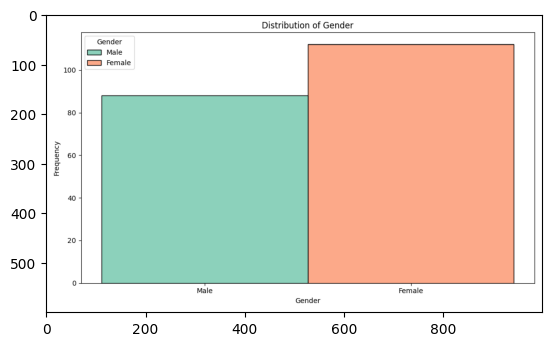

Generating plots:   5%|▍         | 1/22 [00:00<00:02,  7.06plot/s]

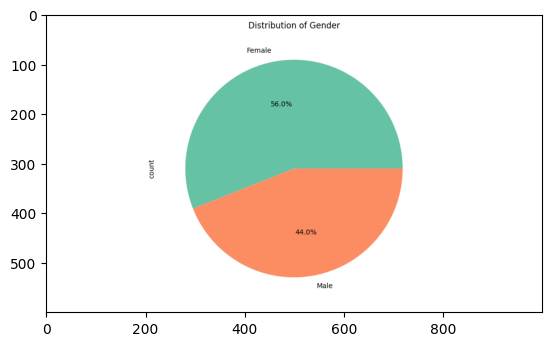

Generating plots:   9%|▉         | 2/22 [00:00<00:02,  6.82plot/s]

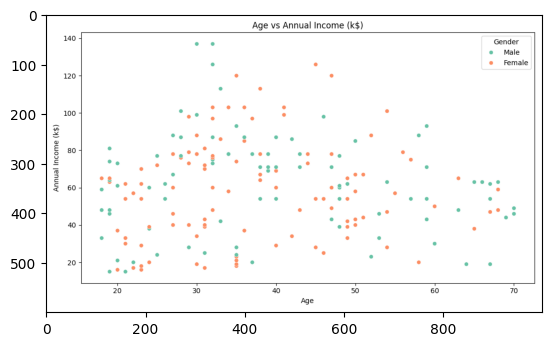

Generating plots:  14%|█▎        | 3/22 [00:00<00:02,  6.75plot/s]

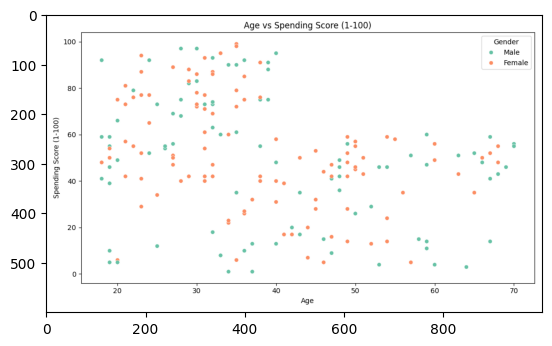

Generating plots:  18%|█▊        | 4/22 [00:00<00:02,  6.73plot/s]

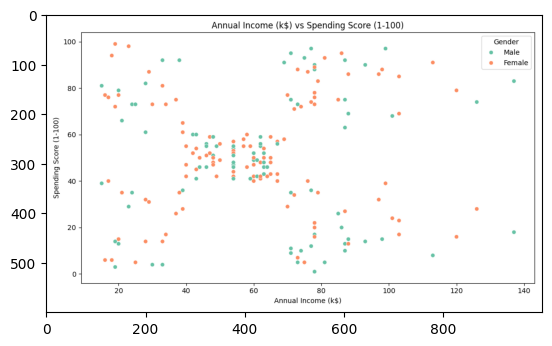

Generating plots:  23%|██▎       | 5/22 [00:00<00:02,  6.70plot/s]

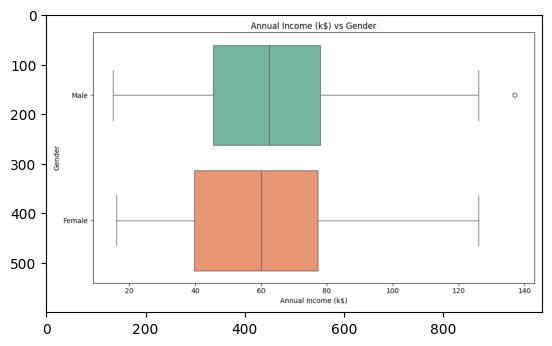

Generating plots:  27%|██▋       | 6/22 [00:00<00:02,  6.44plot/s]

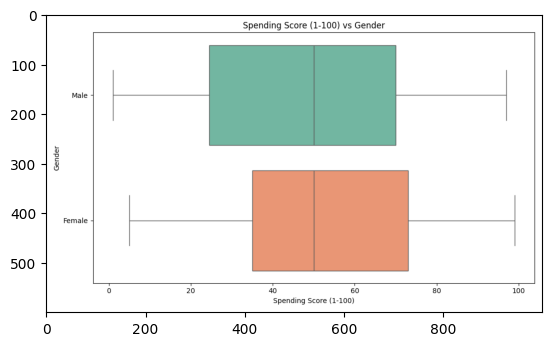

Generating plots:  32%|███▏      | 7/22 [00:01<00:02,  6.63plot/s]

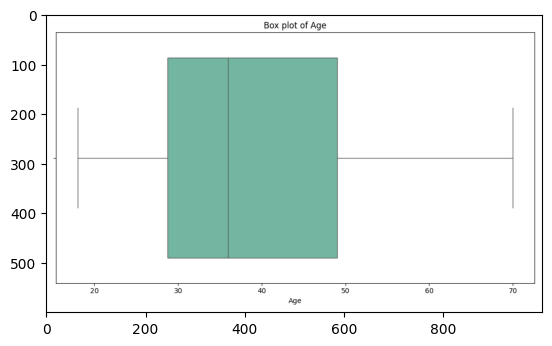

Generating plots:  36%|███▋      | 8/22 [00:01<00:02,  6.64plot/s]

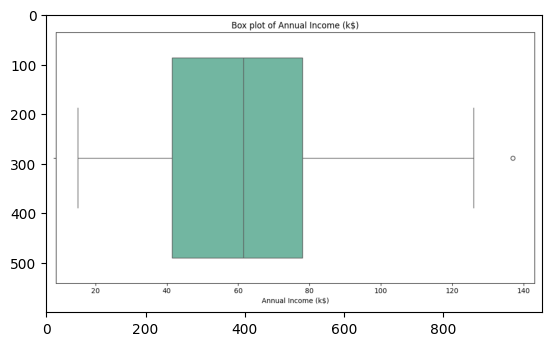

Generating plots:  41%|████      | 9/22 [00:01<00:01,  6.77plot/s]

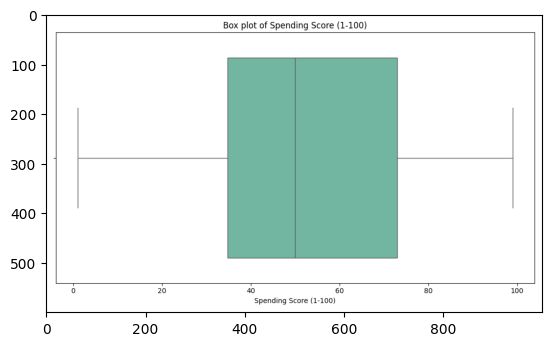

Generating plots:  45%|████▌     | 10/22 [00:01<00:01,  6.86plot/s]

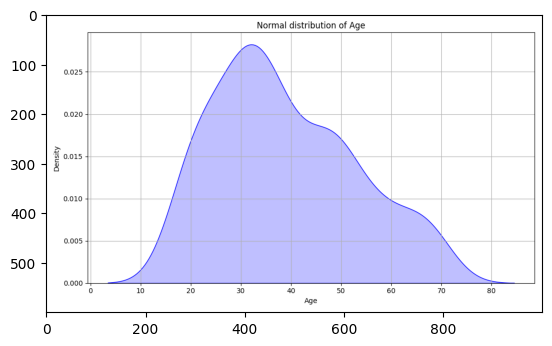

Generating plots:  50%|█████     | 11/22 [00:01<00:01,  6.80plot/s]

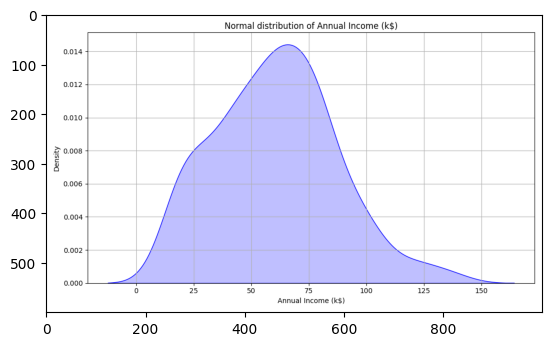

Generating plots:  55%|█████▍    | 12/22 [00:01<00:01,  6.87plot/s]

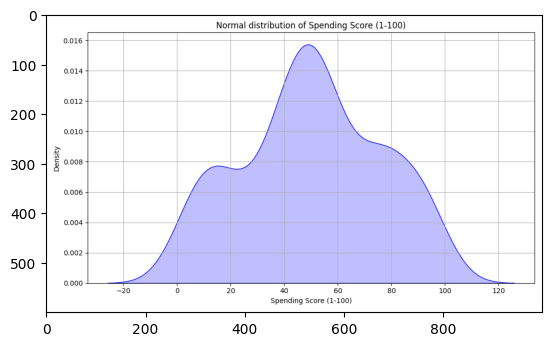

Generating plots:  59%|█████▉    | 13/22 [00:01<00:01,  6.37plot/s]

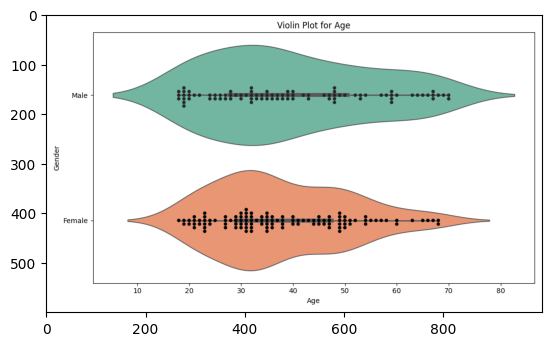

Generating plots:  64%|██████▎   | 14/22 [00:02<00:01,  6.46plot/s]

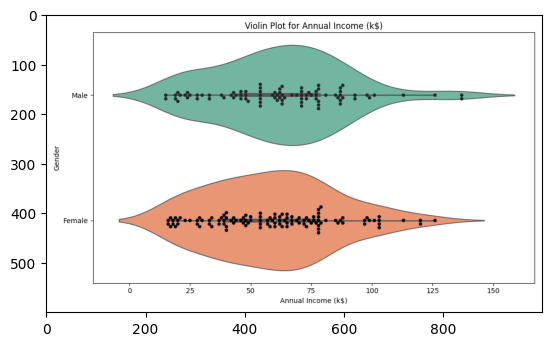

Generating plots:  68%|██████▊   | 15/22 [00:02<00:01,  6.12plot/s]

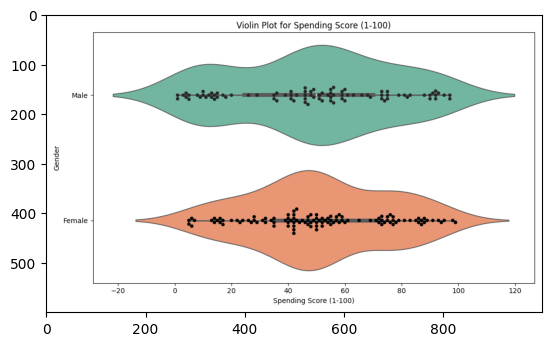

Generating plots:  73%|███████▎  | 16/22 [00:02<00:00,  6.24plot/s]

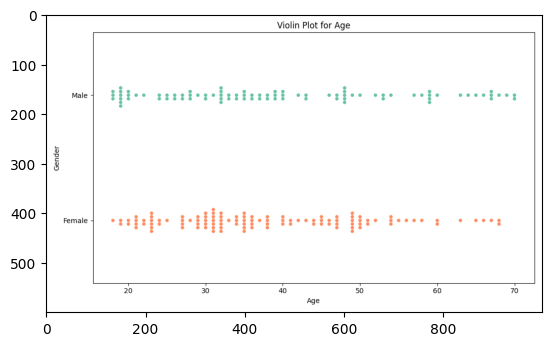

Generating plots:  77%|███████▋  | 17/22 [00:02<00:00,  6.40plot/s]

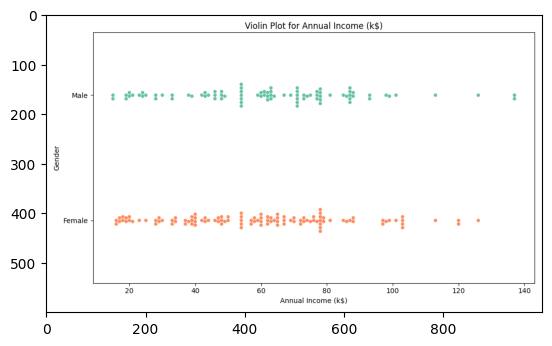

Generating plots:  82%|████████▏ | 18/22 [00:02<00:00,  6.58plot/s]

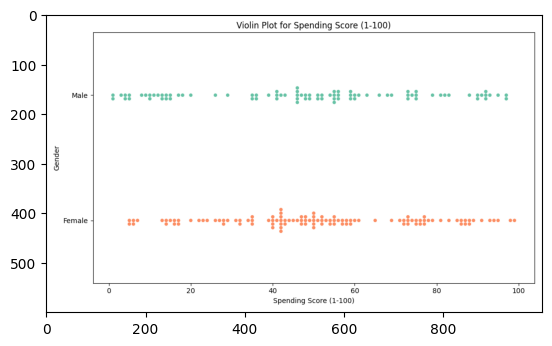

Generating plots:  86%|████████▋ | 19/22 [00:02<00:00,  6.72plot/s]

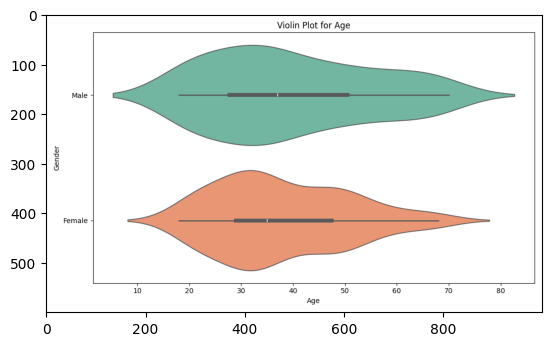

Generating plots:  91%|█████████ | 20/22 [00:03<00:00,  6.28plot/s]

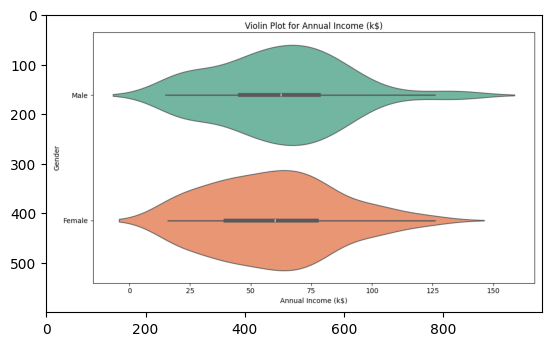

Generating plots:  95%|█████████▌| 21/22 [00:03<00:00,  6.39plot/s]

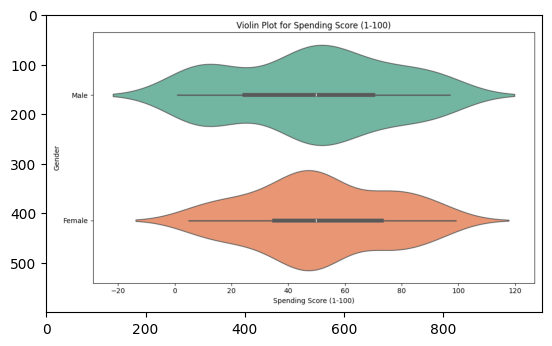

Generating plots: 100%|██████████| 22/22 [00:03<00:00,  6.55plot/s]

Plots generated successfully


In [21]:
Monitor.run(data, dir="raw")

## Outliers Removed

In [22]:
outlierremoval = OutlierRemoval(data)

### IQR

In [23]:
data_outliers_removed_IQR = outlierremoval.remove_outliers_IQR()

In [24]:
data_outliers_removed_IQR

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
194,Female,38,113,91
195,Female,47,120,16
196,Female,35,120,79


In [25]:
preprocessor = Preprocessor(data_outliers_removed_IQR)
data_preprocessed_IQR = preprocessor.preprocess()
data_preprocessed_IQR

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510


### Z-Score

In [26]:
data_outliers_removed_zscore = outlierremoval.remove_outliers_zscore()

In [27]:
preprocessor = Preprocessor(data_outliers_removed_zscore)
data_preprocessed_zscore = preprocessor.preprocess()
data_preprocessed_zscore

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510


### IQR and Z-Score

In [28]:
data_outliers_removed_zscore_IQR = outlierremoval.remove_outliers_zscore_IQR()

In [29]:
preprocessor = Preprocessor(data_outliers_removed_zscore_IQR)
data_preprocessed_zscore_IQR = preprocessor.preprocess()
data_preprocessed_zscore_IQR

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510


In [30]:
diff1 = data_preprocessed_IQR.compare(data_preprocessed_zscore, align_axis=0)
diff2 = data_preprocessed_IQR.compare(data_preprocessed_zscore_IQR, align_axis=0)
diff3 = data_preprocessed_zscore.compare(data_preprocessed_zscore_IQR, align_axis=0)

In [31]:
print("Differences between IQR and Z-score:")
print(diff1)
print("Differences between IQR and Z-score with IQR:")
print(diff2)
print("Differences between Z-score and Z-score with IQR:")
print(diff3)

Differences between IQR and Z-score:
Empty DataFrame
Columns: []
Index: []
Differences between IQR and Z-score with IQR:
Empty DataFrame
Columns: []
Index: []
Differences between Z-score and Z-score with IQR:
Empty DataFrame
Columns: []
Index: []


- No difference between the two methods in the number of outliers detected

In [32]:
data_preprocessed_no_outliers_no_gender = data_preprocessed_IQR.drop(columns=["Gender"])
data_preprocessed_no_outliers = data_preprocessed_IQR.copy()

# HyperOpt Class & Utility Functions

In [33]:
class HyperOpt:
    
    def __init__(self, model, model_name, data, scoring):
        self.data = data
        self.model = model
        self.model_name = model_name
        self.scoring = scoring
    
    def objective(self, trial):
        params = self.get_params(trial)
        model = self.model(**params)
        model.fit(self.data)
        if self.scoring == "silhouette":
            score = silhouette_score(self.data, model.labels_)
        elif self.scoring == "davies_bouldin":
            score = davies_bouldin_score(self.data, model.labels_)
        elif self.scoring == "calinski_harabasz":
            score = calinski_harabasz_score(self.data, model.labels_)
        return score
    def run_study(self, n_trials=100):
        if self.scoring == "silhouette":
            direction = "maximize"
        elif self.scoring == "calinski_harabasz":
            direction = "maximize"
        elif self.scoring == "davies_bouldin":
            direction = "minimize"
        study = optuna.create_study(direction=direction)
        study.optimize(self.objective, n_trials=n_trials, n_jobs=-1)
        return study.best_params   
    def get_params(self, trial):
        if self.model_name == "KMeans":
            return {
                "n_clusters": trial.suggest_int("n_clusters", 2, 10),
                "init": trial.suggest_categorical("init", ["k-means++", "random"]),
                "n_init": trial.suggest_int("n_init", 10, 100),
                "max_iter": trial.suggest_int("max_iter", 100, 1000),
            } 
        elif self.model_name == "AgglomerativeClustering":
            return {
                "n_clusters": trial.suggest_int("n_clusters", 2, 10),
                "linkage": trial.suggest_categorical("linkage", ["ward", "complete", "average", "single"]),
            }

def elbow_method(model_obj, num_clusters, params, data):
    distortions = []
    for k in range(2, num_clusters+1):
        params['n_clusters'] = k
        model = model_obj()
        model.set_params(**params)
        model.fit(data)
        distortions.append(model.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(list(range(2,num_clusters+1)), distortions, "bx-")
    plt.xlabel("k")
    plt.ylabel("Distortion")
    plt.title("The Elbow Method showing the optimal k")
    plt.tight_layout()
    plt.savefig(os.path.join(Utils.plot_dir, "elbow_method.png"))
    plt.show()

def plot_3d_clusters(model_obj, params,data, title, plot_dir):
    model = model_obj(**params)
    model.fit(data)
    labels = model.labels_
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data["Annual Income (k$)"], data["Spending Score (1-100)"], data["Age"], c=labels, cmap="viridis")
    ax.set_xlabel("Annual Income (k$)")
    ax.set_ylabel("Spending Score (1-100)")
    ax.set_zlabel("Age")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f"3d_clusters_{title}.png"))
    plt.show()

def plot_dendogram(data, plot_dir, params):
    method = params["linkage"]
    n_clusters = params["n_clusters"]
    
    Z = linkage(data, method=method)
    
    distances = Z[:, 2]  
    cut_off_distance = distances[-(n_clusters)]
    plt.figure(figsize=(10, 6))
    dendrogram(Z)
    plt.axhline(y=cut_off_distance, color='r', linestyle='--', label=f'{n_clusters} Clusters')    
    plt.title(f"Dendrogram ({method} linkage)")
    plt.xlabel("Sample index")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "dendogram.png"))
    plt.show()

# Modelling with Outliers Removed Gender available

In [34]:
data_preprocessed_no_outliers

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510


### KMeans Model

In [35]:
kmeans_silhouette = HyperOpt(KMeans, "KMeans", data_preprocessed_no_outliers, "silhouette")
kmeans_davis_bouldin = HyperOpt(KMeans, "KMeans", data_preprocessed_no_outliers, "davies_bouldin")
kmeans_calinski_harabasz = HyperOpt(KMeans, "KMeans", data_preprocessed_no_outliers, "calinski_harabasz")

best_params_kmeans_silhouette = kmeans_silhouette.run_study(n_trials=100)
best_params_kmeans_davis_bouldin = kmeans_davis_bouldin.run_study(n_trials=100)
best_params_kmeans_calinski_harabasz = kmeans_calinski_harabasz.run_study(n_trials=100)


[I 2024-11-29 10:41:40,502] A new study created in memory with name: no-name-bcc7e1b7-ccb6-43d1-98fa-b7b6011b917c
[I 2024-11-29 10:41:40,984] Trial 6 finished with value: 0.3554256746559882 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 18, 'max_iter': 449}. Best is trial 6 with value: 0.3554256746559882.
[I 2024-11-29 10:41:41,043] Trial 0 finished with value: 0.37234611142426316 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 19, 'max_iter': 547}. Best is trial 0 with value: 0.37234611142426316.
[I 2024-11-29 10:41:41,159] Trial 2 finished with value: 0.5134898112863674 and parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 63, 'max_iter': 357}. Best is trial 2 with value: 0.5134898112863674.
[I 2024-11-29 10:41:41,193] Trial 8 finished with value: 0.3554256746559882 and parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 13, 'max_iter': 360}. Best is trial 2 with value: 0.5134898112863674.
[I 2024-11-29 10:41:41,343] Trial 5 finished w

In [36]:
best_params_kmeans_calinski_harabasz, best_params_kmeans_davis_bouldin, best_params_kmeans_silhouette

({'n_clusters': 2, 'init': 'random', 'n_init': 38, 'max_iter': 595},
 {'n_clusters': 2, 'init': 'k-means++', 'n_init': 84, 'max_iter': 499},
 {'n_clusters': 2, 'init': 'k-means++', 'n_init': 63, 'max_iter': 357})

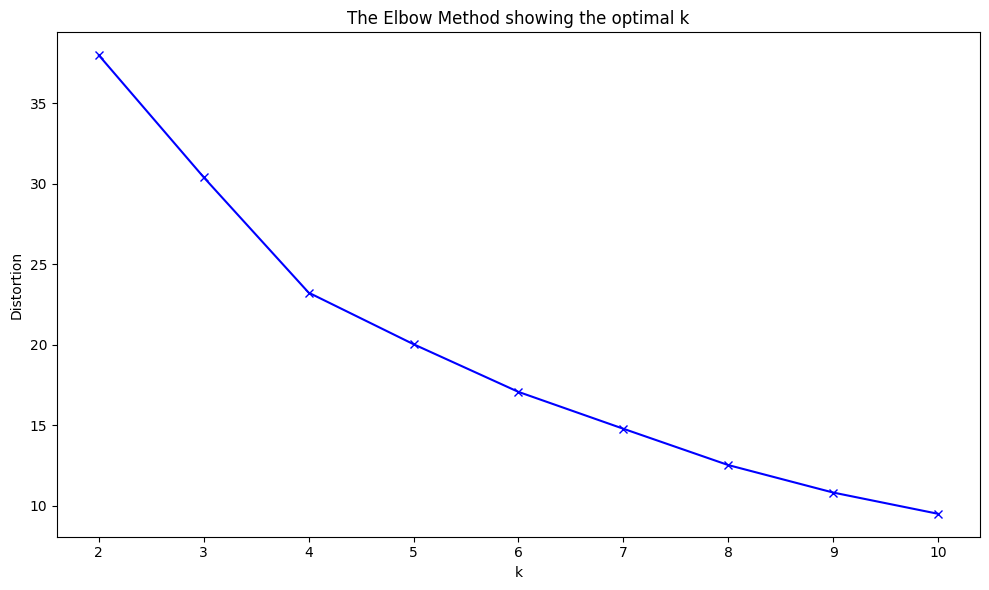

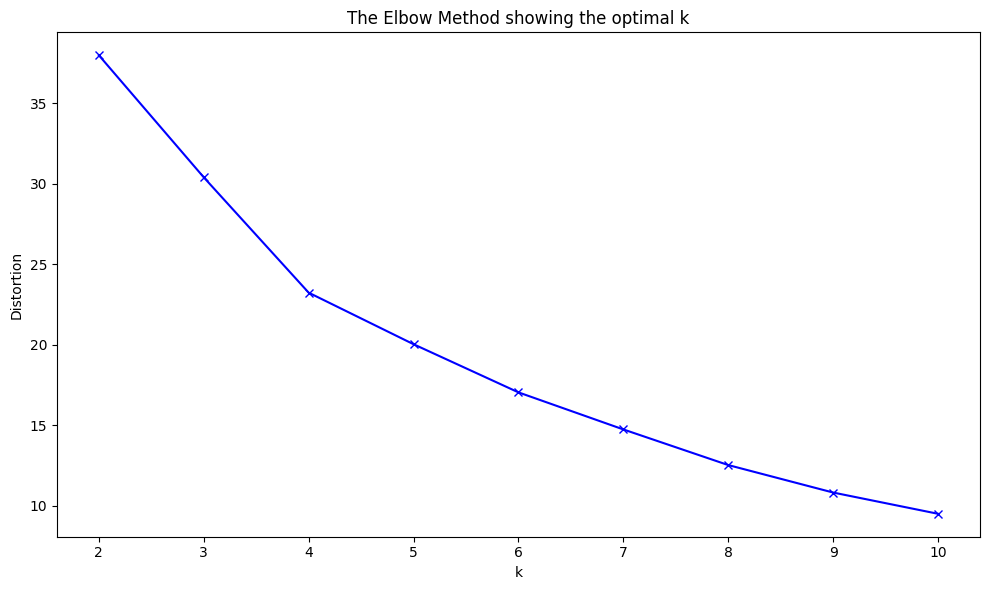

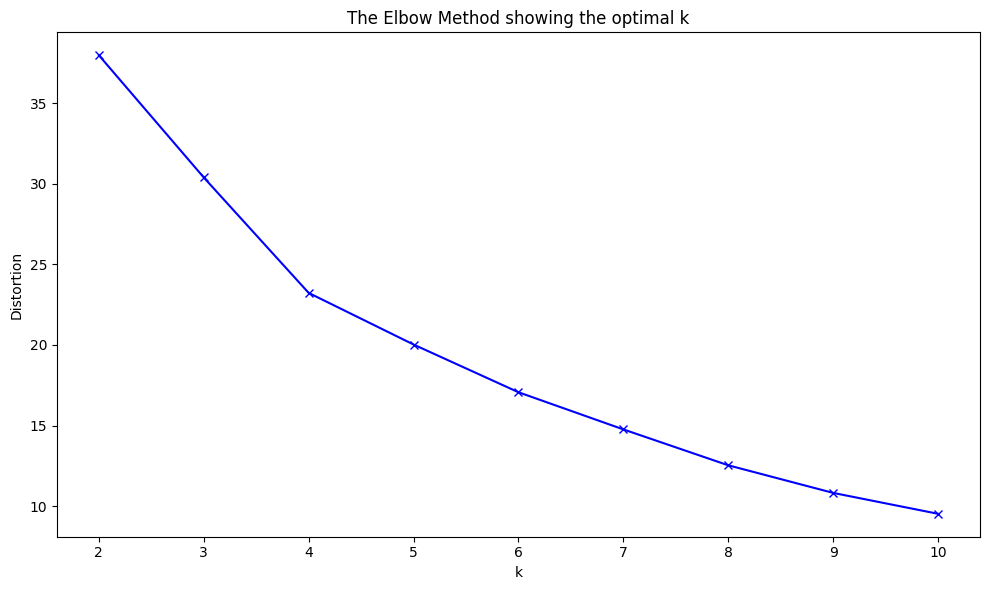

In [37]:
elbow_method(KMeans, 10, best_params_kmeans_silhouette, data_preprocessed_no_outliers)
elbow_method(KMeans, 10, best_params_kmeans_davis_bouldin, data_preprocessed_no_outliers)
elbow_method(KMeans, 10, best_params_kmeans_calinski_harabasz, data_preprocessed_no_outliers)

In [38]:
best_params_elbow_method = {
    "n_clusters": 4, # From the elbow method
}

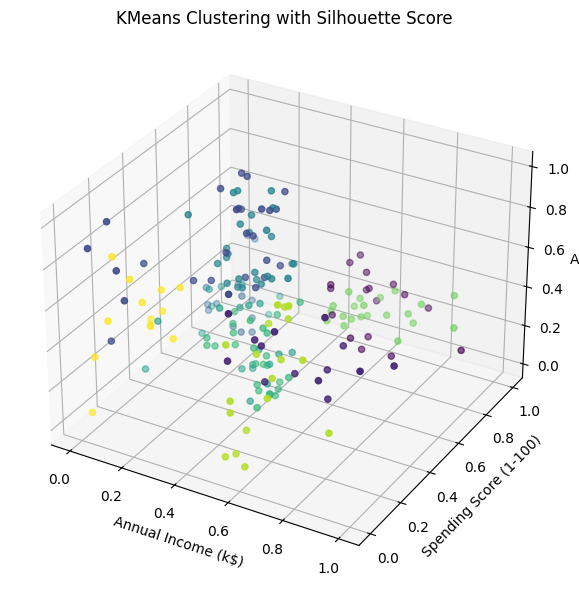

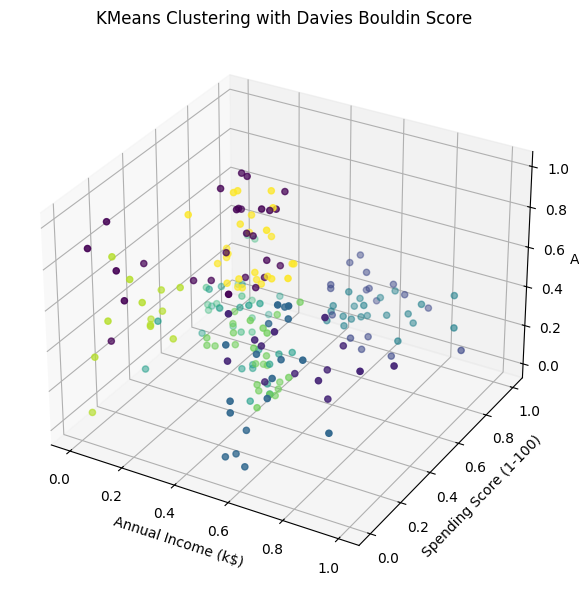

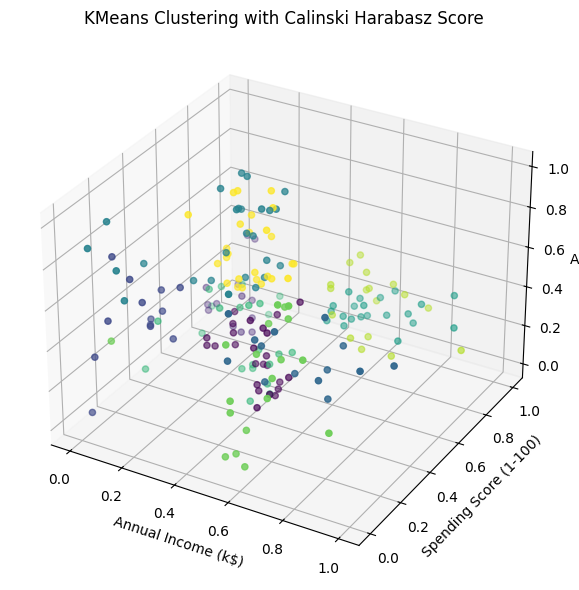

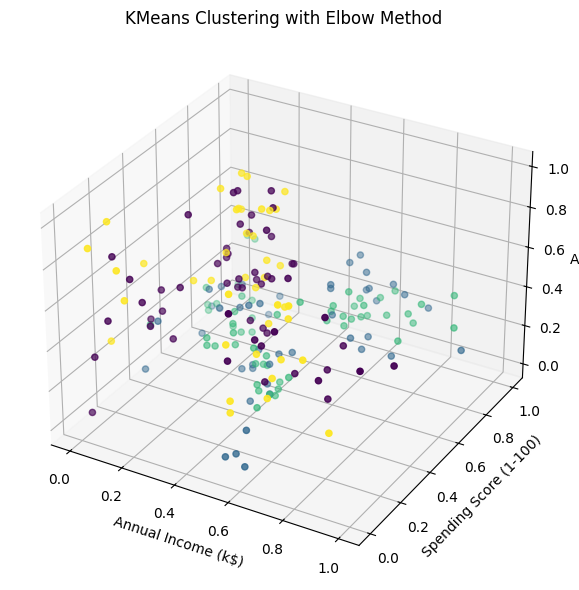

In [39]:
plot_3d_clusters(KMeans, best_params_kmeans_silhouette, data_preprocessed_no_outliers, "KMeans Clustering with Silhouette Score", Utils.plot_dir)
plot_3d_clusters(KMeans, best_params_kmeans_davis_bouldin, data_preprocessed_no_outliers, "KMeans Clustering with Davies Bouldin Score", Utils.plot_dir)
plot_3d_clusters(KMeans, best_params_kmeans_calinski_harabasz, data_preprocessed_no_outliers, "KMeans Clustering with Calinski Harabasz Score", Utils.plot_dir)
plot_3d_clusters(KMeans, best_params_elbow_method, data_preprocessed_no_outliers, "KMeans Clustering with Elbow Method", Utils.plot_dir)

### Agglomerative Model

In [40]:
agglomerativeClustering_silhouette = HyperOpt(AgglomerativeClustering, "AgglomerativeClustering", data_preprocessed_no_outliers, "silhouette")
agglomerativeClustering_davis_bouldin = HyperOpt(AgglomerativeClustering, "AgglomerativeClustering", data_preprocessed_no_outliers, "davies_bouldin")
agglomerativeClustering_calinski_harabasz = HyperOpt(AgglomerativeClustering, "AgglomerativeClustering", data_preprocessed_no_outliers, "calinski_harabasz")

best_paramas_agglomerativeClustering_silhouette = agglomerativeClustering_silhouette.run_study(n_trials=100)
best_paramas_agglomerativeClustering_davis_bouldin = agglomerativeClustering_davis_bouldin.run_study(n_trials=100)
best_paramas_agglomerativeClustering_calinski_harabasz = agglomerativeClustering_calinski_harabasz.run_study(n_trials=100)

[I 2024-11-29 10:42:19,005] A new study created in memory with name: no-name-bf7e525d-4d36-443e-a30f-1e00051a1056
[I 2024-11-29 10:42:19,047] Trial 7 finished with value: 0.3428877730222844 and parameters: {'n_clusters': 4, 'linkage': 'average'}. Best is trial 7 with value: 0.3428877730222844.
[I 2024-11-29 10:42:19,056] Trial 6 finished with value: 0.3428877730222844 and parameters: {'n_clusters': 4, 'linkage': 'average'}. Best is trial 7 with value: 0.3428877730222844.
[I 2024-11-29 10:42:19,056] Trial 3 finished with value: 0.4471924321341753 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 3 with value: 0.4471924321341753.
[I 2024-11-29 10:42:19,056] Trial 4 finished with value: 0.3576577411589508 and parameters: {'n_clusters': 6, 'linkage': 'average'}. Best is trial 3 with value: 0.4471924321341753.
[I 2024-11-29 10:42:19,056] Trial 2 finished with value: 0.3739196745281734 and parameters: {'n_clusters': 7, 'linkage': 'ward'}. Best is trial 3 with value: 0.44

In [41]:
best_paramas_agglomerativeClustering_silhouette ,best_paramas_agglomerativeClustering_davis_bouldin, best_paramas_agglomerativeClustering_calinski_harabasz

({'n_clusters': 2, 'linkage': 'single'},
 {'n_clusters': 5, 'linkage': 'single'},
 {'n_clusters': 2, 'linkage': 'average'})

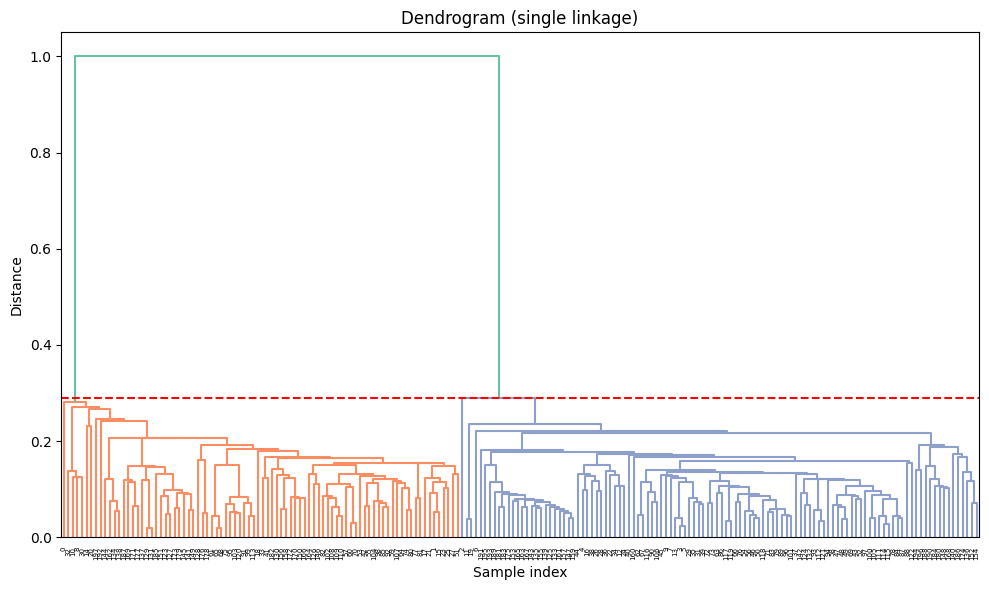

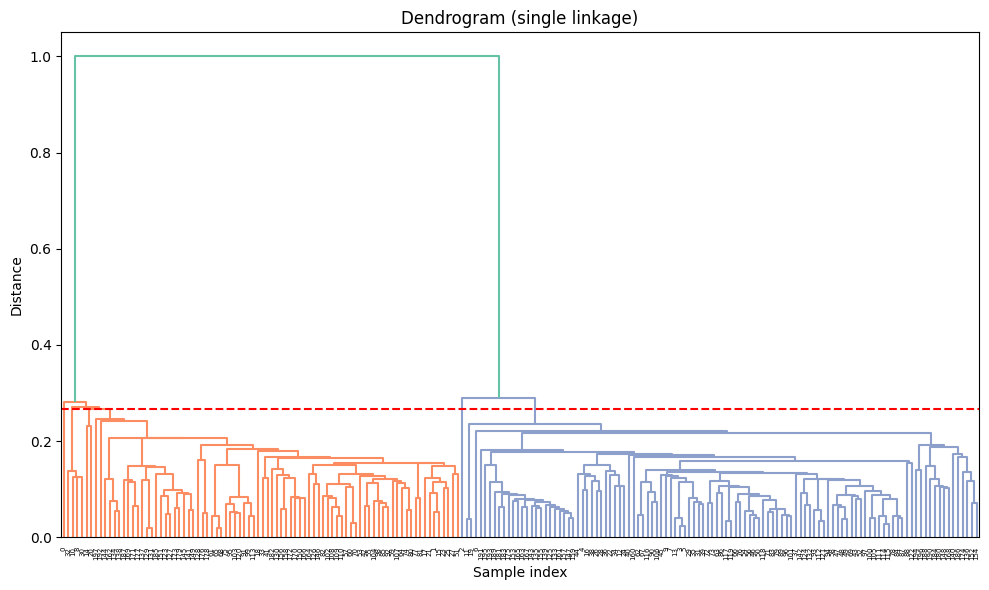

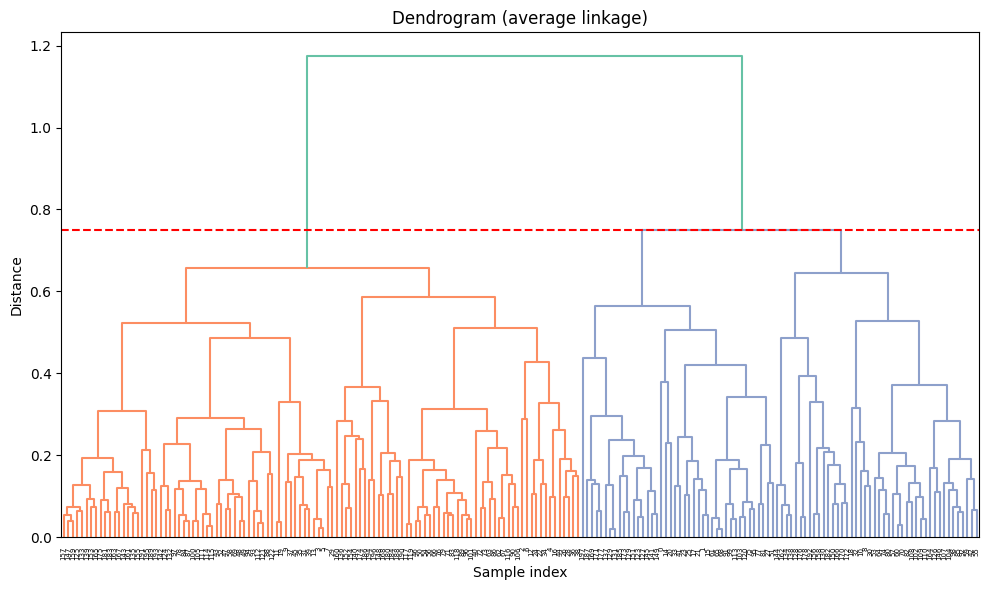

In [42]:
plot_dendogram(data_preprocessed_no_outliers, Utils.plot_dir, best_paramas_agglomerativeClustering_silhouette)
plot_dendogram(data_preprocessed_no_outliers, Utils.plot_dir, best_paramas_agglomerativeClustering_davis_bouldin)
plot_dendogram(data_preprocessed_no_outliers, Utils.plot_dir, best_paramas_agglomerativeClustering_calinski_harabasz)

# Modelling with Outliers Removed, Gender Removed

### KMeans Model

In [43]:
kmeans_silhouette = HyperOpt(KMeans, "KMeans", data_preprocessed_no_outliers_no_gender, "silhouette")
kmeans_davis_bouldin = HyperOpt(KMeans, "KMeans", data_preprocessed_no_outliers_no_gender, "davies_bouldin")
kmeans_calinski_harabasz = HyperOpt(KMeans, "KMeans", data_preprocessed_no_outliers_no_gender, "calinski_harabasz")

best_params_kmeans_silhouette = kmeans_silhouette.run_study(n_trials=100)
best_params_kmeans_davis_bouldin = kmeans_davis_bouldin.run_study(n_trials=100)
best_params_kmeans_calinski_harabasz = kmeans_calinski_harabasz.run_study(n_trials=100)

[I 2024-11-29 10:42:28,843] A new study created in memory with name: no-name-72555d41-ccef-4d26-8ef3-2face2c32919
[I 2024-11-29 10:42:29,149] Trial 7 finished with value: 0.39676539723807025 and parameters: {'n_clusters': 10, 'init': 'k-means++', 'n_init': 14, 'max_iter': 893}. Best is trial 7 with value: 0.39676539723807025.
[I 2024-11-29 10:42:29,476] Trial 6 finished with value: 0.3571110529133075 and parameters: {'n_clusters': 2, 'init': 'random', 'n_init': 71, 'max_iter': 150}. Best is trial 7 with value: 0.39676539723807025.
[I 2024-11-29 10:42:29,508] Trial 3 finished with value: 0.42115676188943685 and parameters: {'n_clusters': 10, 'init': 'random', 'n_init': 58, 'max_iter': 958}. Best is trial 3 with value: 0.42115676188943685.
[I 2024-11-29 10:42:29,617] Trial 0 finished with value: 0.3639300224683962 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 72, 'max_iter': 648}. Best is trial 3 with value: 0.42115676188943685.
[I 2024-11-29 10:42:29,711] Trial 1 finishe

In [44]:
best_params_kmeans_calinski_harabasz, best_params_kmeans_davis_bouldin, best_params_kmeans_silhouette

({'n_clusters': 9, 'init': 'k-means++', 'n_init': 94, 'max_iter': 281},
 {'n_clusters': 7, 'init': 'random', 'n_init': 84, 'max_iter': 809},
 {'n_clusters': 10, 'init': 'k-means++', 'n_init': 74, 'max_iter': 177})

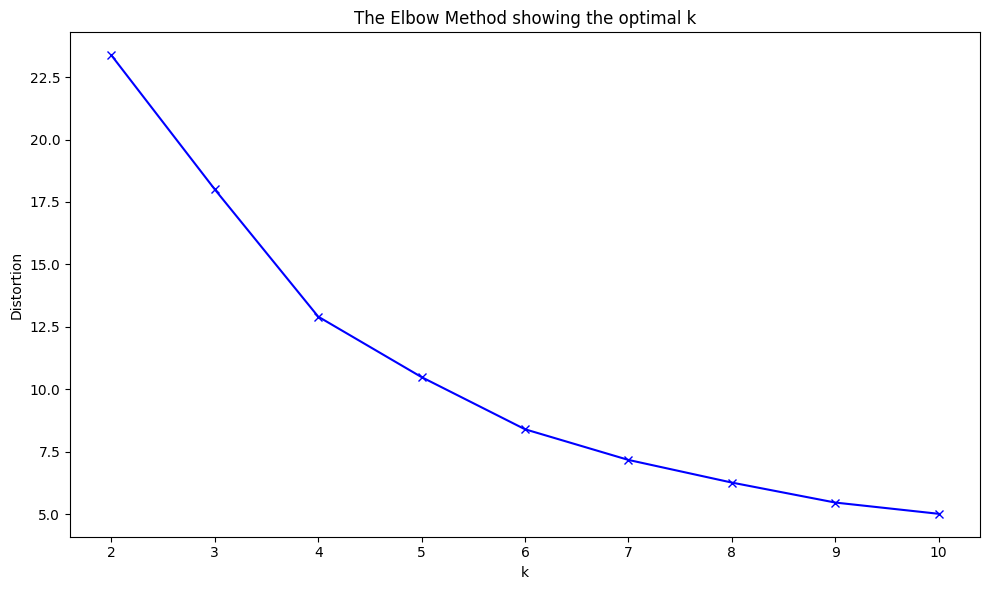

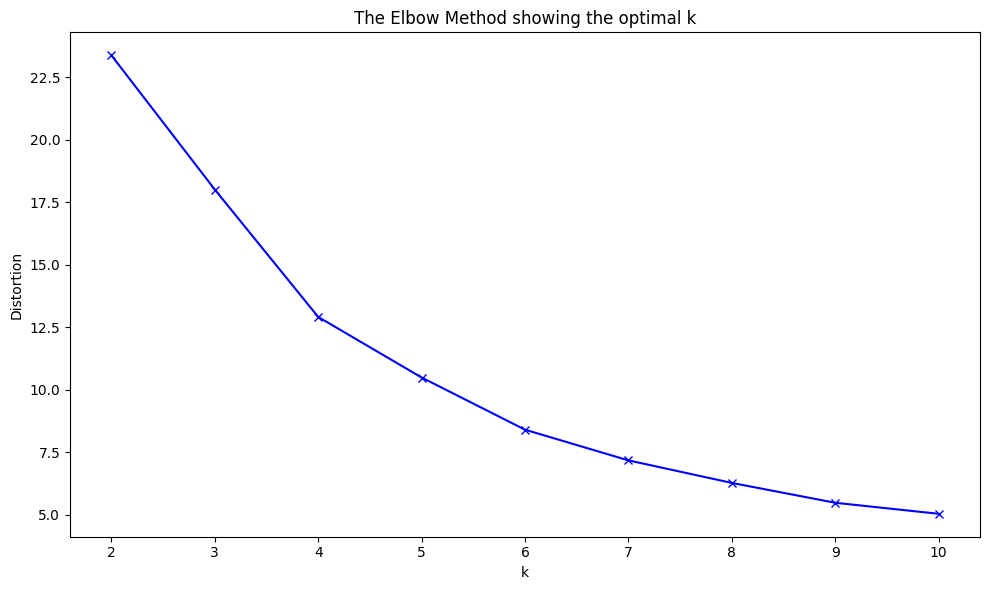

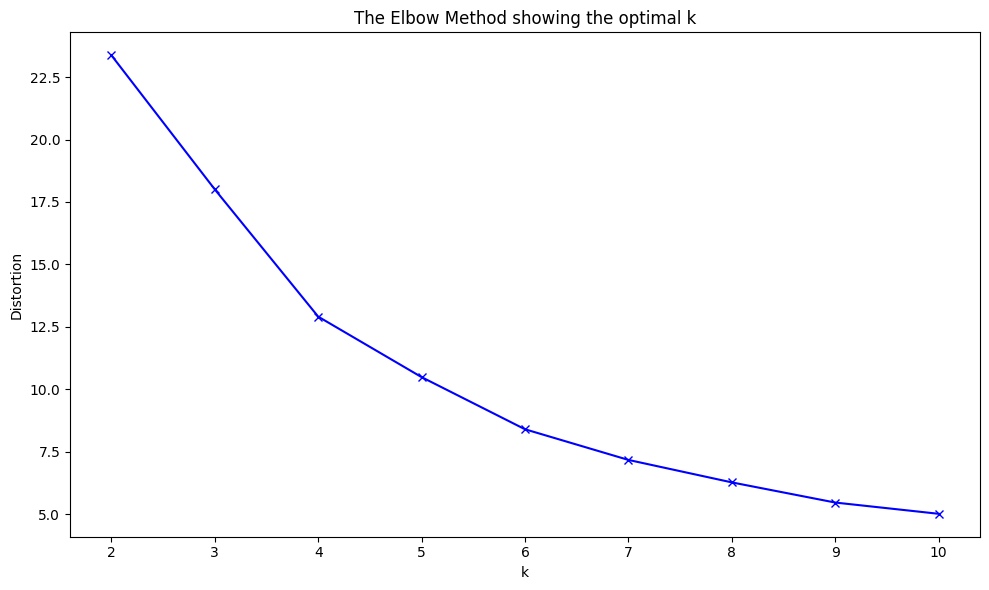

In [45]:
elbow_method(KMeans, 10, best_params_kmeans_silhouette, data_preprocessed_no_outliers_no_gender)
elbow_method(KMeans, 10, best_params_kmeans_davis_bouldin, data_preprocessed_no_outliers_no_gender)
elbow_method(KMeans, 10, best_params_kmeans_calinski_harabasz, data_preprocessed_no_outliers_no_gender)

In [46]:
best_params_elbow_method = {
    "n_clusters": 4, # From the elbow method
}

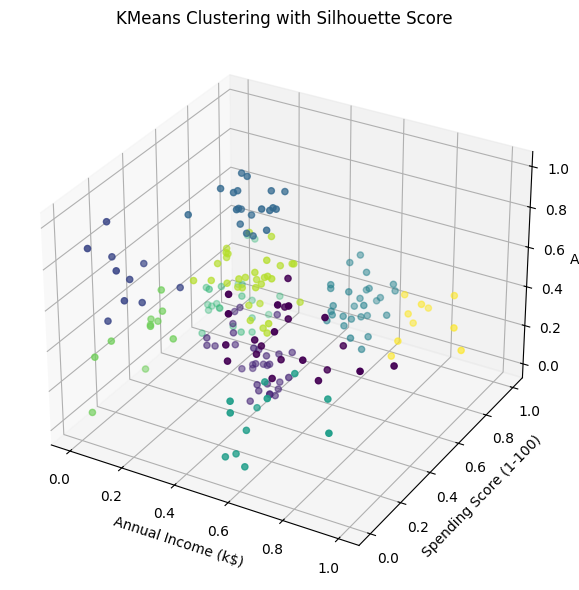

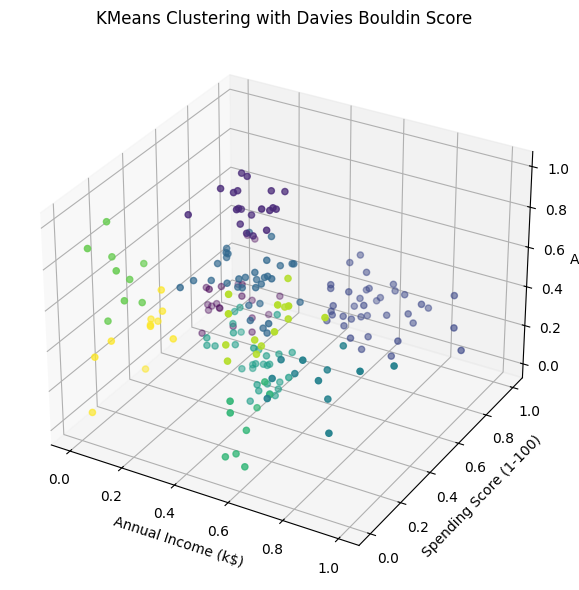

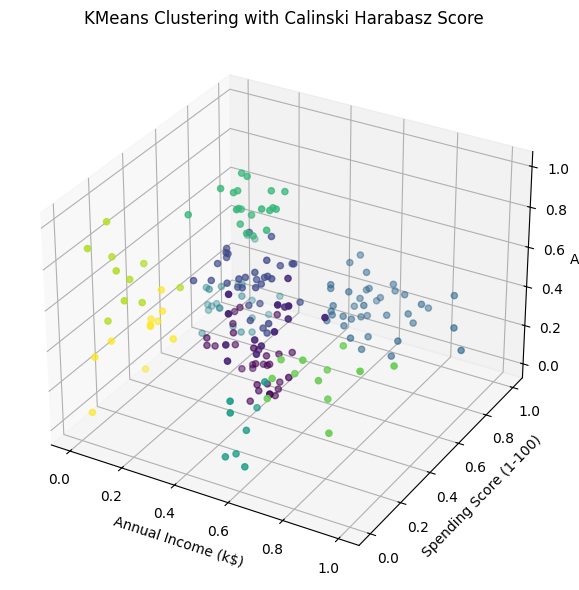

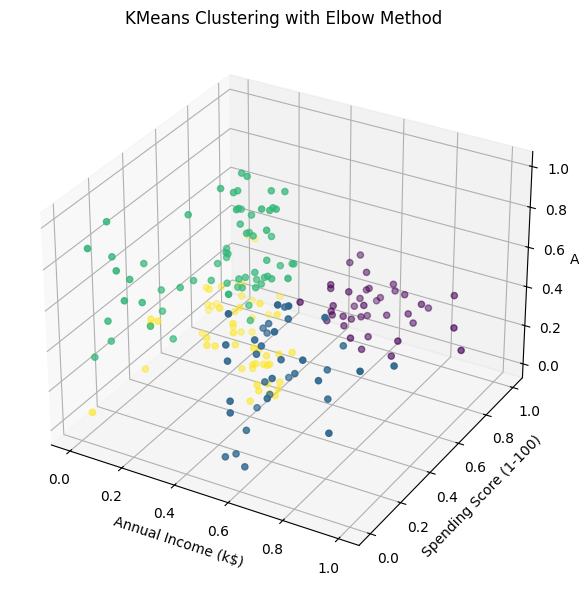

In [47]:
plot_3d_clusters(KMeans, best_params_kmeans_silhouette, data_preprocessed_no_outliers_no_gender, "KMeans Clustering with Silhouette Score", Utils.plot_dir)
plot_3d_clusters(KMeans, best_params_kmeans_davis_bouldin, data_preprocessed_no_outliers_no_gender, "KMeans Clustering with Davies Bouldin Score", Utils.plot_dir)
plot_3d_clusters(KMeans, best_params_kmeans_calinski_harabasz, data_preprocessed_no_outliers_no_gender, "KMeans Clustering with Calinski Harabasz Score", Utils.plot_dir)
plot_3d_clusters(KMeans, best_params_elbow_method, data_preprocessed_no_outliers_no_gender, "KMeans Clustering with Elbow Method", Utils.plot_dir)

### Agglomerative Model

In [48]:
agglomerativeClustering_silhouette = HyperOpt(AgglomerativeClustering, "AgglomerativeClustering", data_preprocessed_no_outliers_no_gender, "silhouette")
agglomerativeClustering_davis_bouldin = HyperOpt(AgglomerativeClustering, "AgglomerativeClustering", data_preprocessed_no_outliers_no_gender, "davies_bouldin")
agglomerativeClustering_calinski_harabasz = HyperOpt(AgglomerativeClustering, "AgglomerativeClustering", data_preprocessed_no_outliers_no_gender, "calinski_harabasz")

best_paramas_agglomerativeClustering_silhouette = agglomerativeClustering_silhouette.run_study(n_trials=100)
best_paramas_agglomerativeClustering_davis_bouldin = agglomerativeClustering_davis_bouldin.run_study(n_trials=100)
best_paramas_agglomerativeClustering_calinski_harabasz = agglomerativeClustering_calinski_harabasz.run_study(n_trials=100)

[I 2024-11-29 10:43:21,842] A new study created in memory with name: no-name-f179c10f-3541-4bb7-a9a6-ab5f60022136
[I 2024-11-29 10:43:21,879] Trial 1 finished with value: -0.05956706277746841 and parameters: {'n_clusters': 5, 'linkage': 'single'}. Best is trial 1 with value: -0.05956706277746841.
[I 2024-11-29 10:43:21,879] Trial 2 finished with value: 0.38922806432896334 and parameters: {'n_clusters': 10, 'linkage': 'average'}. Best is trial 2 with value: 0.38922806432896334.
[I 2024-11-29 10:43:21,888] Trial 0 finished with value: 0.39338877653691645 and parameters: {'n_clusters': 7, 'linkage': 'complete'}. Best is trial 0 with value: 0.39338877653691645.
[I 2024-11-29 10:43:21,896] Trial 3 finished with value: 0.10444472105923121 and parameters: {'n_clusters': 3, 'linkage': 'single'}. Best is trial 0 with value: 0.39338877653691645.
[I 2024-11-29 10:43:21,904] Trial 5 finished with value: 0.40573947216363904 and parameters: {'n_clusters': 5, 'linkage': 'ward'}. Best is trial 5 with 

In [49]:
best_paramas_agglomerativeClustering_silhouette ,best_paramas_agglomerativeClustering_davis_bouldin, best_paramas_agglomerativeClustering_calinski_harabasz

({'n_clusters': 9, 'linkage': 'ward'},
 {'n_clusters': 2, 'linkage': 'single'},
 {'n_clusters': 7, 'linkage': 'ward'})

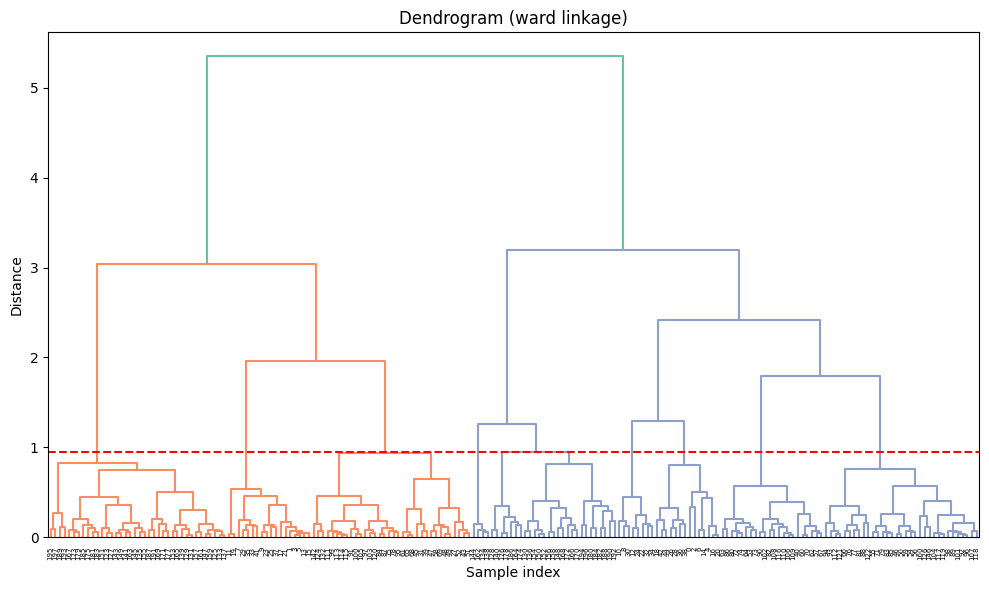

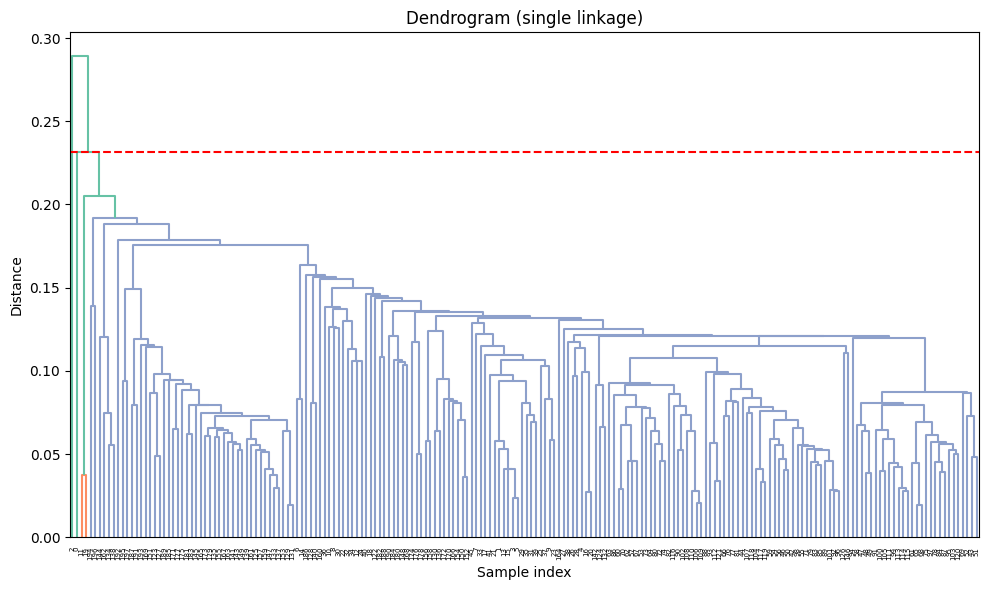

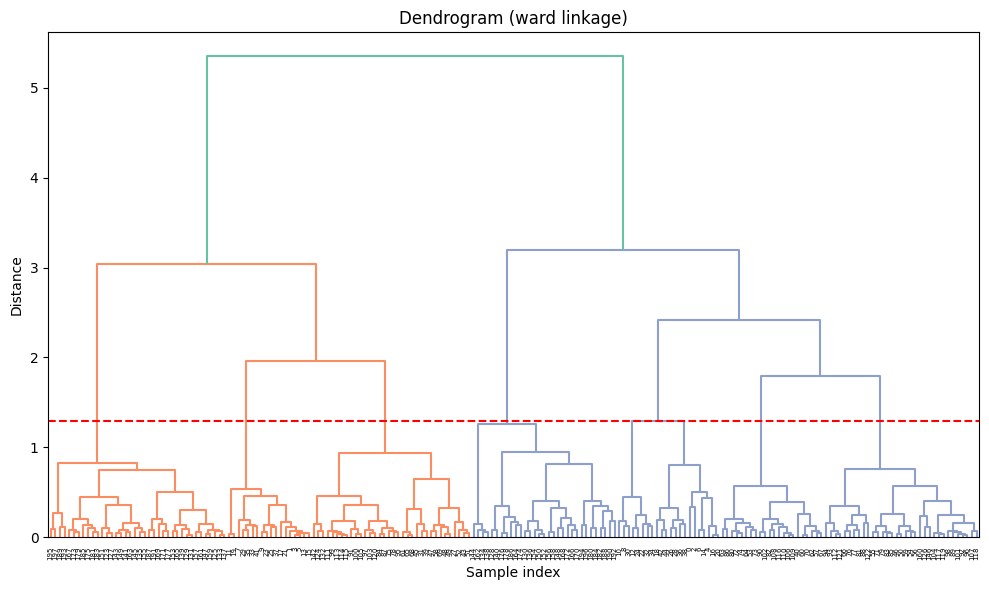

In [50]:
plot_dendogram(data_preprocessed_no_outliers_no_gender, Utils.plot_dir, best_paramas_agglomerativeClustering_silhouette)
plot_dendogram(data_preprocessed_no_outliers_no_gender, Utils.plot_dir, best_paramas_agglomerativeClustering_davis_bouldin)
plot_dendogram(data_preprocessed_no_outliers_no_gender, Utils.plot_dir, best_paramas_agglomerativeClustering_calinski_harabasz)